<a href="https://colab.research.google.com/github/farkhanAdhitama/flask-traffic-sign-detection-yolo11/blob/main/Indonesia-Traffic-Sign-Object-Detection-with-YOLO11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Indonesia Traffic Sign Object Detection with YOLO11 </h1>

# GPU Check

In [ ]:
!nvidia-smi

Mon Jan 13 01:39:04 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Library

In [ ]:
# ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 20.2 MB/s eta 0:00:00


In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
from collections import Counter


# Indonesia Traffic Sign Dataset

## Download and Extract Dataset from Kaggle

In [ ]:
!kaggle datasets download -d ikbal12082004/traffic-sign-in-indonesia

Dataset URL: https://www.kaggle.com/datasets/ikbal12082004/traffic-sign-in-indonesia
License(s): MIT
 99% 881M/888M [00:10<00:00, 107MB/s]
100% 888M/888M [00:10<00:00, 87.7MB/s]


In [ ]:
!unzip traffic-sign-in-indonesia.zip -d traffic-sign-in-indonesia

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: traffic-sign-in-indonesia/train/labels/28-141-_jpg.rf.f25dac4ff11a3ac2a8b978f61552bba5.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-143-_jpg.rf.1b2a06e6602ddaf2cdc83594bf737c46.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-143-_jpg.rf.982a7a94e1b9f941bf30cb8c0c6ab981.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-143-_jpg.rf.d336c7ad76613a822ed820adc73884a2.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-144-_jpg.rf.a9b28ab39ee10c60c9e53141a1f18dcf.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-144-_jpg.rf.ae08c3b096537a3cf730fe72d780f9af.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-144-_jpg.rf.cd1e94919d3cce4d0f679f55f34a281c.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-145-_jpg.rf.2217f5bbb89b34c81afcac2f9bc494b1.txt  
  inflating: traffic-sign-in-indonesia/train/labels/28-145-_jpg.rf.3af50d63d90ae7cac036c8879b

## Show Image Sample

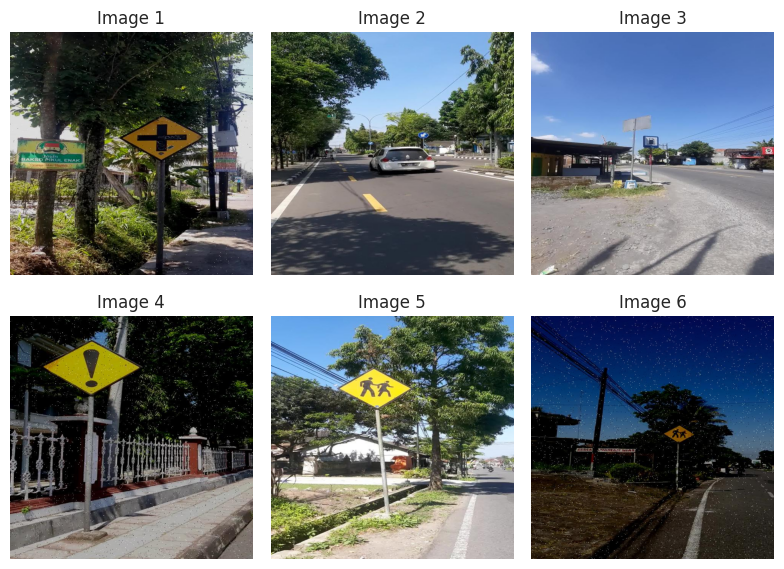

In [ ]:
Image_dir = '/content/traffic-sign-in-indonesia/train/images'

num_samples = 6
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Visualization

## Train Set

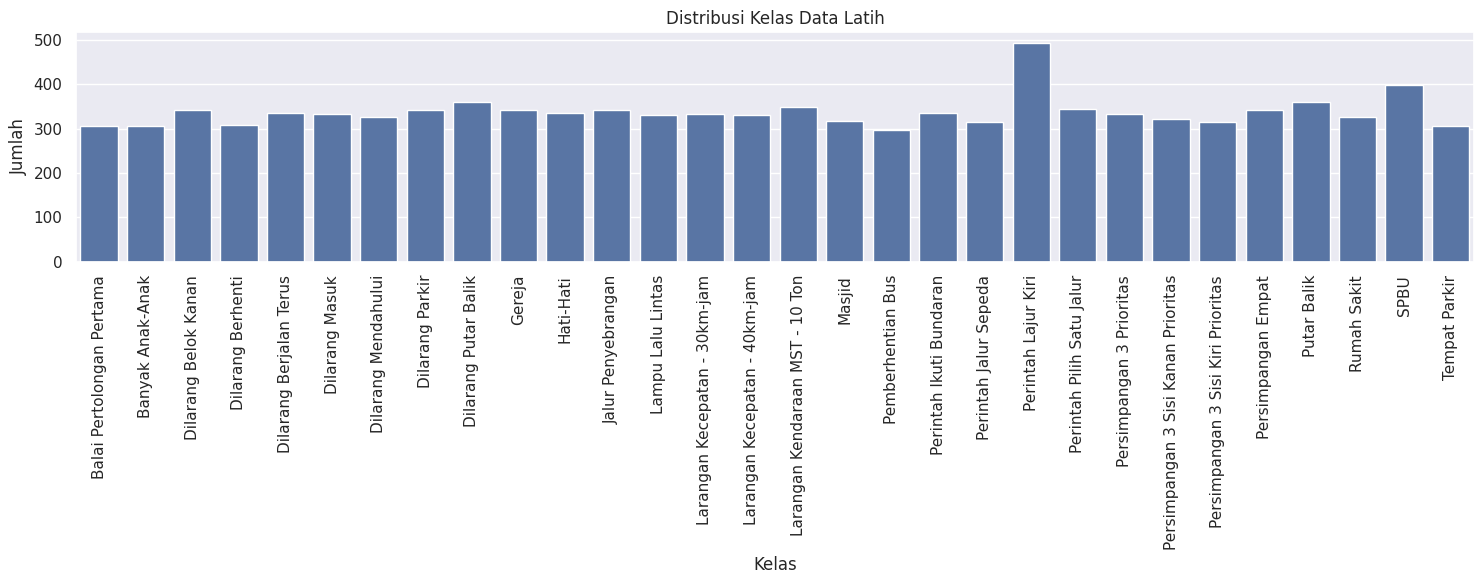

In [ ]:
# Path folder anotasi
train_labels_path = "/content/traffic-sign-in-indonesia/train/labels"
valid_labels_path = "/content/traffic-sign-in-indonesia/valid/labels"
test_labels_path = "/content/traffic-sign-in-indonesia/test/labels"

names = [
    'Balai Pertolongan Pertama', 'Banyak Anak-Anak', 'Dilarang Belok Kanan',
    'Dilarang Berhenti', 'Dilarang Berjalan Terus', 'Dilarang Masuk',
    'Dilarang Mendahului', 'Dilarang Parkir', 'Dilarang Putar Balik', 'Gereja',
    'Hati-Hati', 'Jalur Penyebrangan', 'Lampu Lalu Lintas',
    'Larangan Kecepatan - 30km-jam', 'Larangan Kecepatan - 40km-jam',
    'Larangan Kendaraan MST - 10 Ton', 'Masjid', 'Pemberhentian Bus',
    'Perintah Ikuti Bundaran', 'Perintah Jalur Sepeda', 'Perintah Lajur Kiri',
    'Perintah Pilih Satu Jalur', 'Persimpangan 3 Prioritas',
    'Persimpangan 3 Sisi Kanan Prioritas', 'Persimpangan 3 Sisi Kiri Prioritas',
    'Persimpangan Empat', 'Putar Balik', 'Rumah Sakit', 'SPBU', 'Tempat Parkir'
]

def count_labels(label_path, class_names):
    class_counter = Counter()
    # Iterasi file dalam folder label
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(label_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])  # Ambil ID kelas dari setiap baris
                    class_counter[class_id] += 1
    # Mengurutkan hasil berdasarkan indeks kelas
    frequencies = [class_counter.get(i, 0) for i in range(len(class_names))]
    return frequencies

train_set_frequencies = count_labels(train_labels_path, names)
data_latih = {
    'Kelas': names,
    'Jumlah': train_set_frequencies
}
plt.figure(figsize=(15, 6))
sns.barplot(x=data_latih['Kelas'], y=data_latih['Jumlah'])
plt.xticks(rotation=90)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas Data Latih')
plt.tight_layout()
plt.show()

## Valid Set

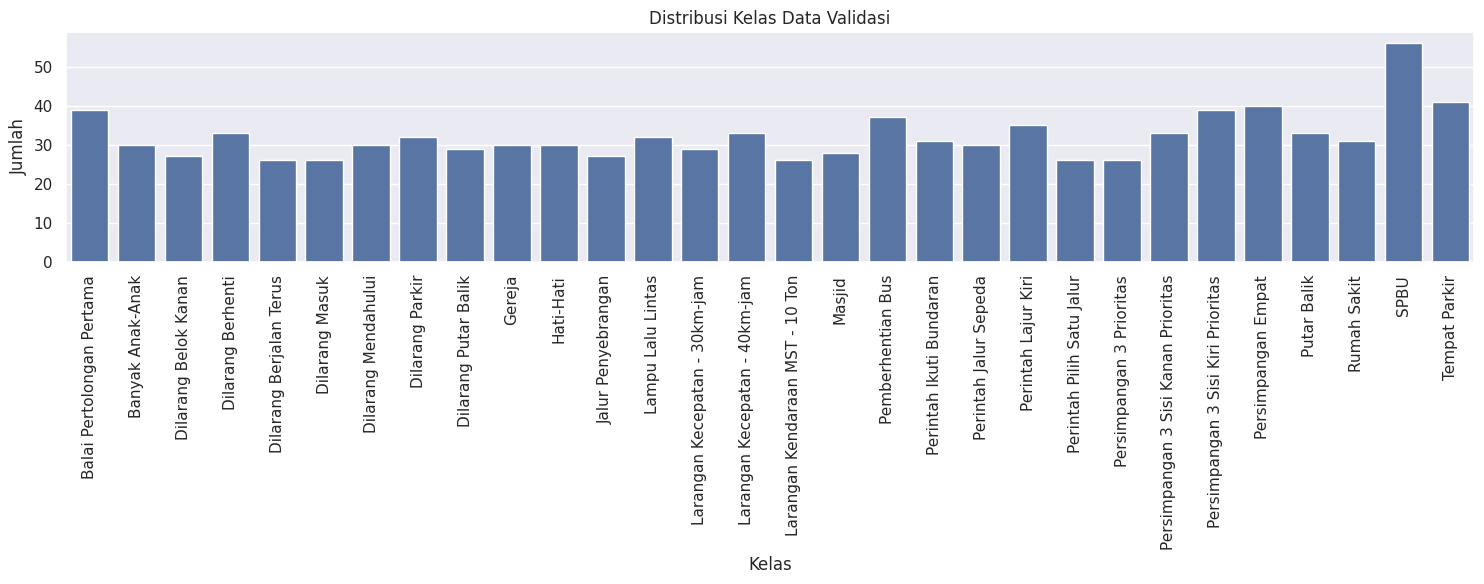

In [ ]:
valid_set_frequencies = count_labels(valid_labels_path, names)
data_valid = {
    'Kelas': names,
    'Jumlah': valid_set_frequencies
}
plt.figure(figsize=(15, 6))
sns.barplot(x=data_valid['Kelas'], y=data_valid['Jumlah'])
plt.xticks(rotation=90)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas Data Validasi')
plt.tight_layout()
plt.show()

## Test Set

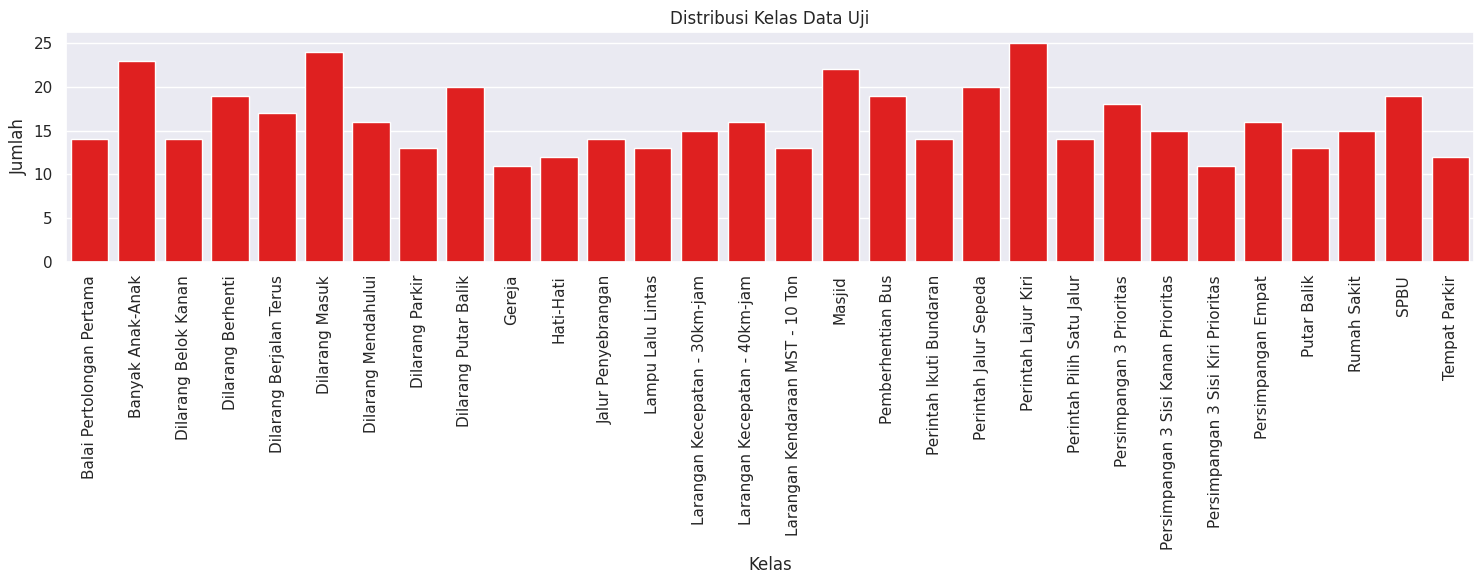

In [ ]:
test_set_frequencies = count_labels(test_labels_path, names)
data_uji = {
    'Kelas': names,
    'Jumlah': test_set_frequencies
}
plt.figure(figsize=(15, 6))
sns.barplot(x=data_uji['Kelas'], y=data_uji['Jumlah'], color='red')
plt.xticks(rotation=90)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas Data Uji')
plt.tight_layout()
plt.show()

## Class Count for Every Set

In [ ]:
# Tabel jumlah data uji tiap kelas
df_uji = pd.DataFrame(data_uji)
df_valid = pd.DataFrame(data_valid)
df_latih = pd.DataFrame(data_latih)

In [ ]:
data_latih_valid = pd.merge(
    df_latih,
    df_valid,
    on="Kelas",
    how="outer",
    suffixes=('_Data_Latih', '_Data_Valid')
)
all_data = pd.merge(
    data_latih_valid,
    df_uji,
    on="Kelas",
    how="outer"
).rename(columns={'Jumlah': 'Jumlah_Data_Uji'})

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Kelas              30 non-null     object
 1   Jumlah_Data_Latih  30 non-null     int64 
 2   Jumlah_Data_Valid  30 non-null     int64 
 3   Jumlah_Data_Uji    30 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


In [ ]:
all_data

Kelas  Jumlah_Data_Latih  Jumlah_Data_Valid  \
0             Balai Pertolongan Pertama                306                 39   
1                      Banyak Anak-Anak                306                 30   
2                  Dilarang Belok Kanan                342                 27   
3                     Dilarang Berhenti                309                 33   
4               Dilarang Berjalan Terus                336                 26   
5                        Dilarang Masuk                333                 26   
6                   Dilarang Mendahului                327                 30   
7                       Dilarang Parkir                342                 32   
8                  Dilarang Putar Balik                360                 29   
9                                Gereja                342                 30   
10                            Hati-Hati                336                 30   
11                   Jalur Penyebrangan                342                 27   
12                    Lampu Lalu Lintas                330                 32   
13        Larangan Kecepatan - 30km-jam                333                 29   
14        Larangan Kecepatan - 40km-jam                330                 33   
15      Larangan Kendaraan MST - 10 Ton                348                 26   
16                               Masjid                318                 28   
17                    Pemberhentian Bus                297                 37   
18              Perintah Ikuti Bundaran                336                 31   
19                Perintah Jalur Sepeda                315                 30   
20                  Perintah Lajur Kiri                492                 35   
21            Perintah Pilih Satu Jalur                345                 26   
22             Persimpangan 3 Prioritas                333                 26   
23  Persimpangan 3 Sisi Kanan Prioritas                321                 33   
24   Persimpangan 3 Sisi Kiri Prioritas                315                 39   
25                   Persimpangan Empat                342                 40   
26                          Putar Balik                360                 33   
27                          Rumah Sakit                327                 31   
28                                 SPBU                399                 56   
29                        Tempat Parkir                306                 41   

    Jumlah_Data_Uji  
0                14  
1                23  
2                14  
3                19  
4                17  
5                24  
6                16  
7                13  
8                20  
9                11  
10               12  
11               14  
12               13  
13               15  
14               16  
15               13  
16               22  
17               19  
18               14  
19               20  
20               25  
21               14  
22               18  
23               15  
24               11  
25               16  
26               13  
27               15  
28               19  
29               12

# Model Training

In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data=/content/traffic-sign-in-indonesia/data.yaml epochs=10 imgsz=640 plots=True

100% 18.4M/18.4M [00:00<00:00, 210MB/s]
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/traffic-sign-in-indonesia/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

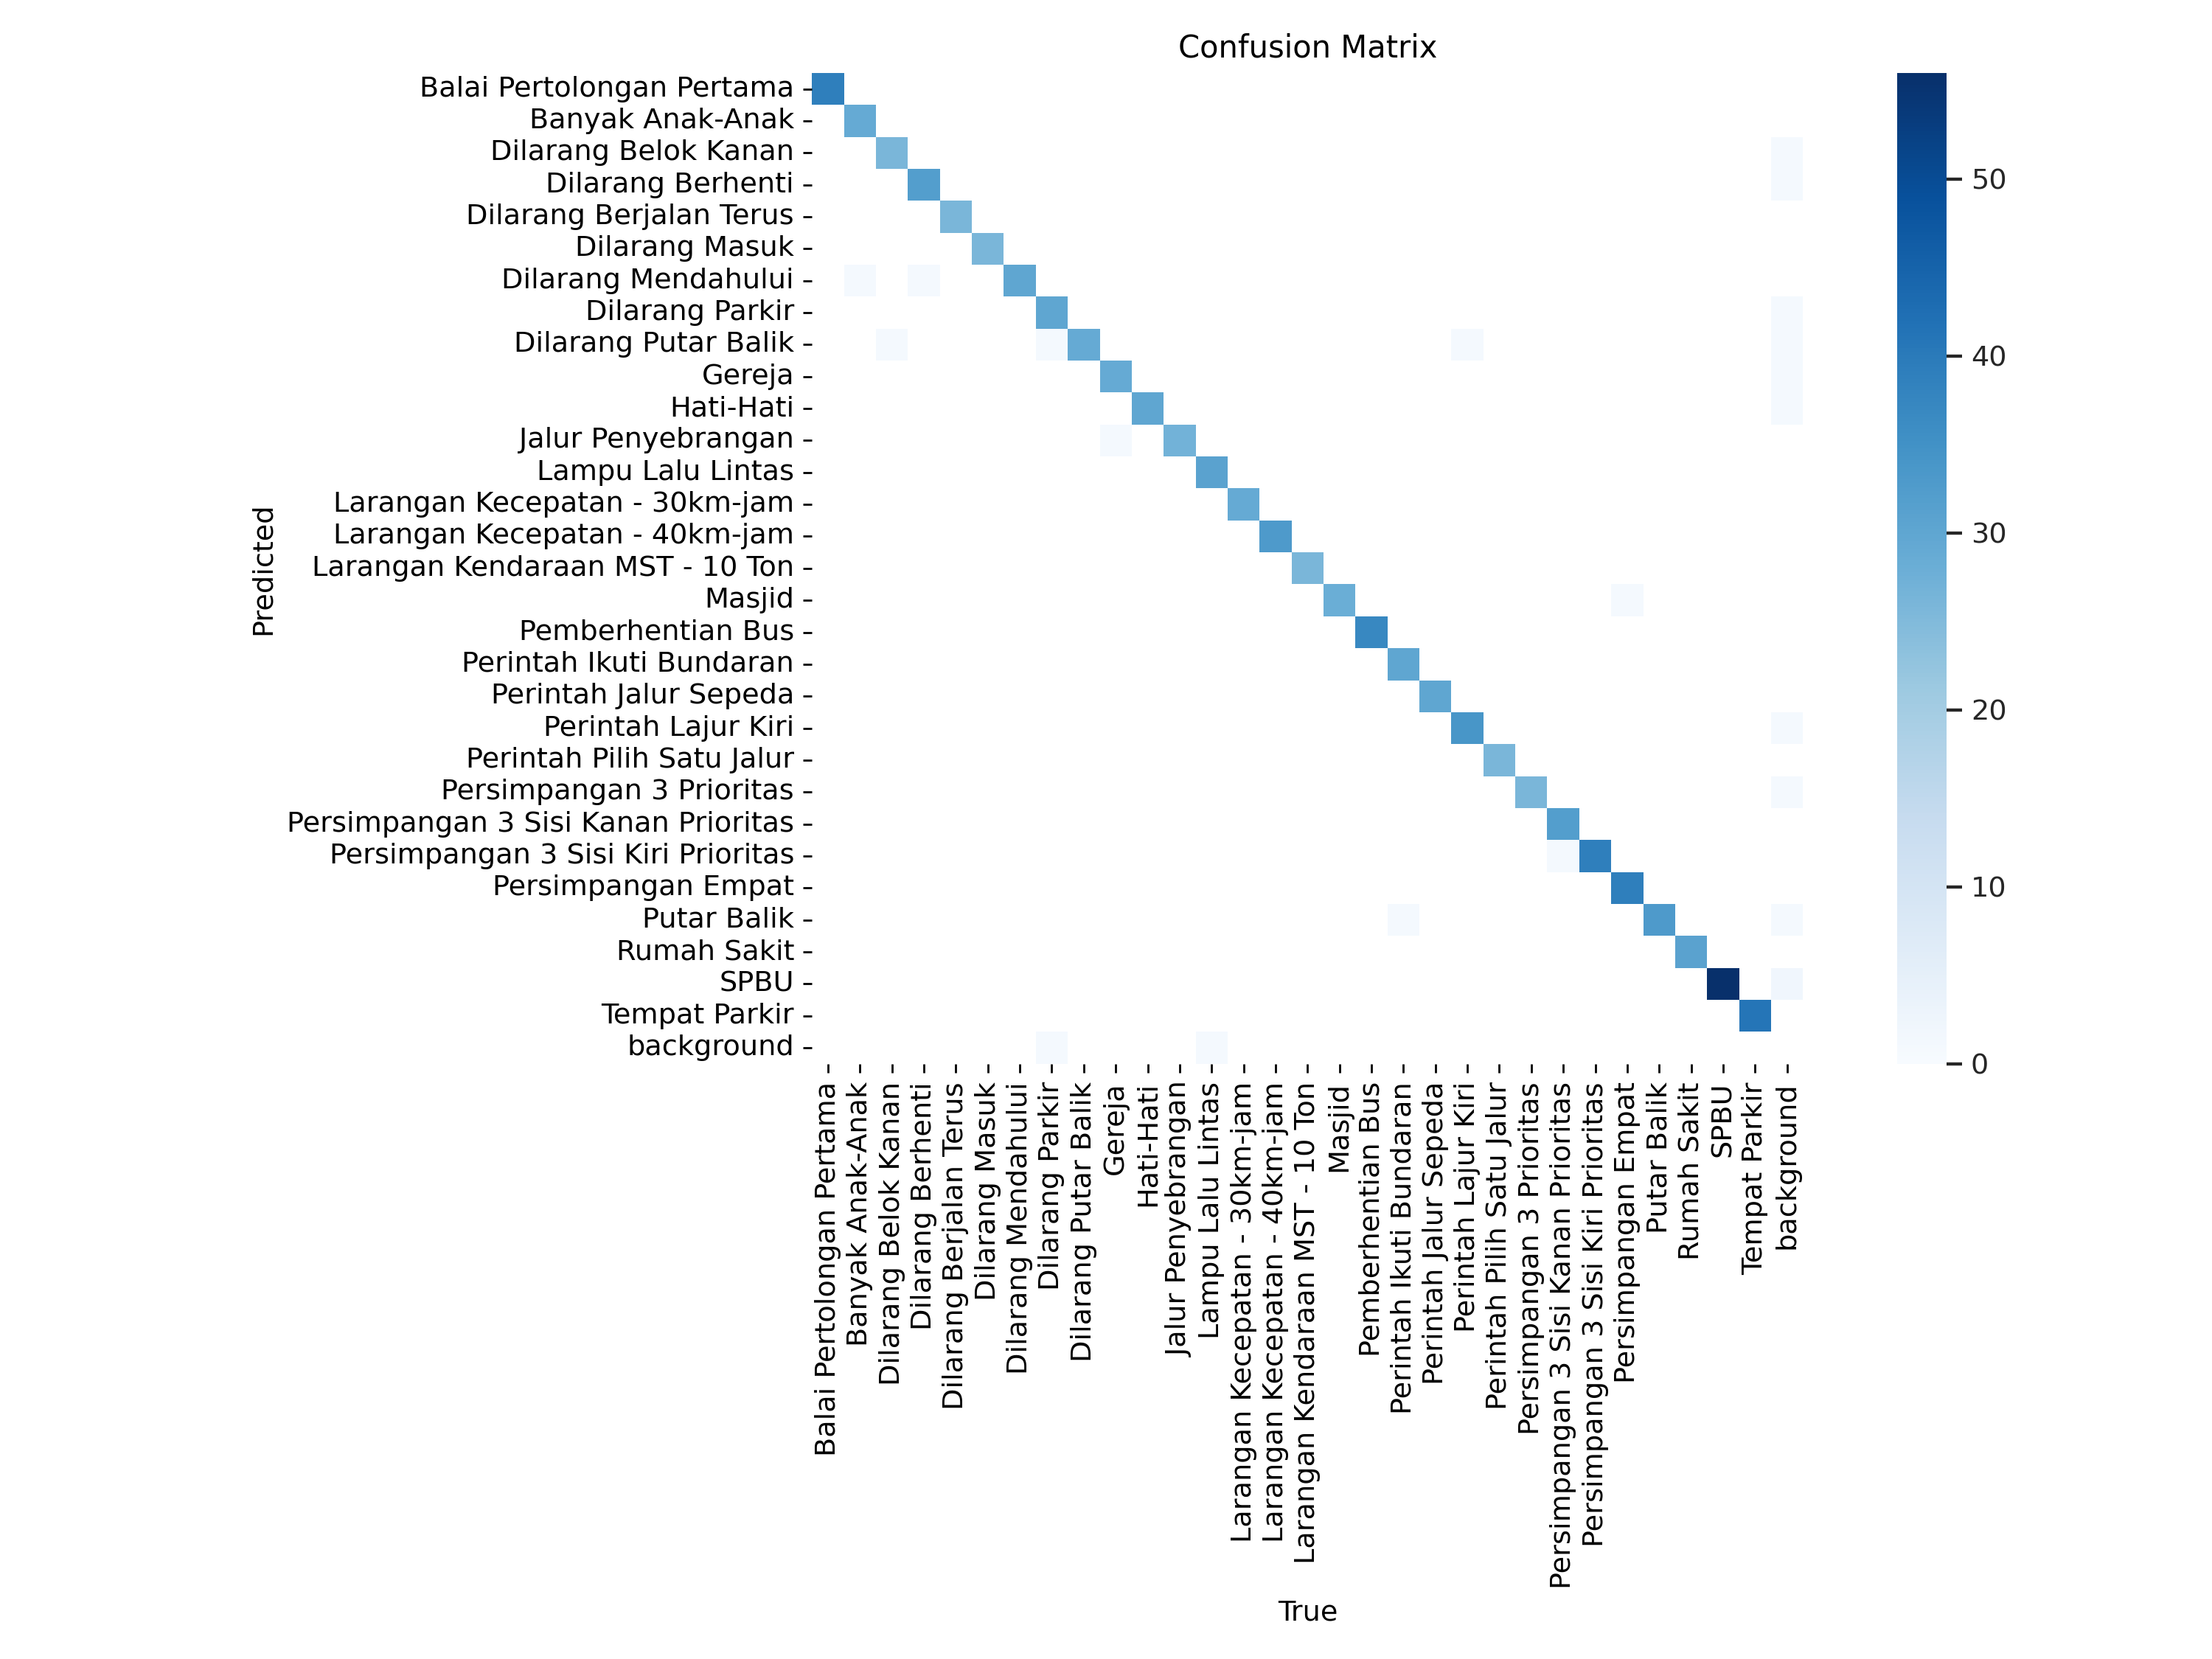

In [ ]:
#confusion matrix
from IPython.display import Image as IPyImage
IPyImage(filename=f'/content/runs/detect/train/confusion_matrix.png', width=1000)

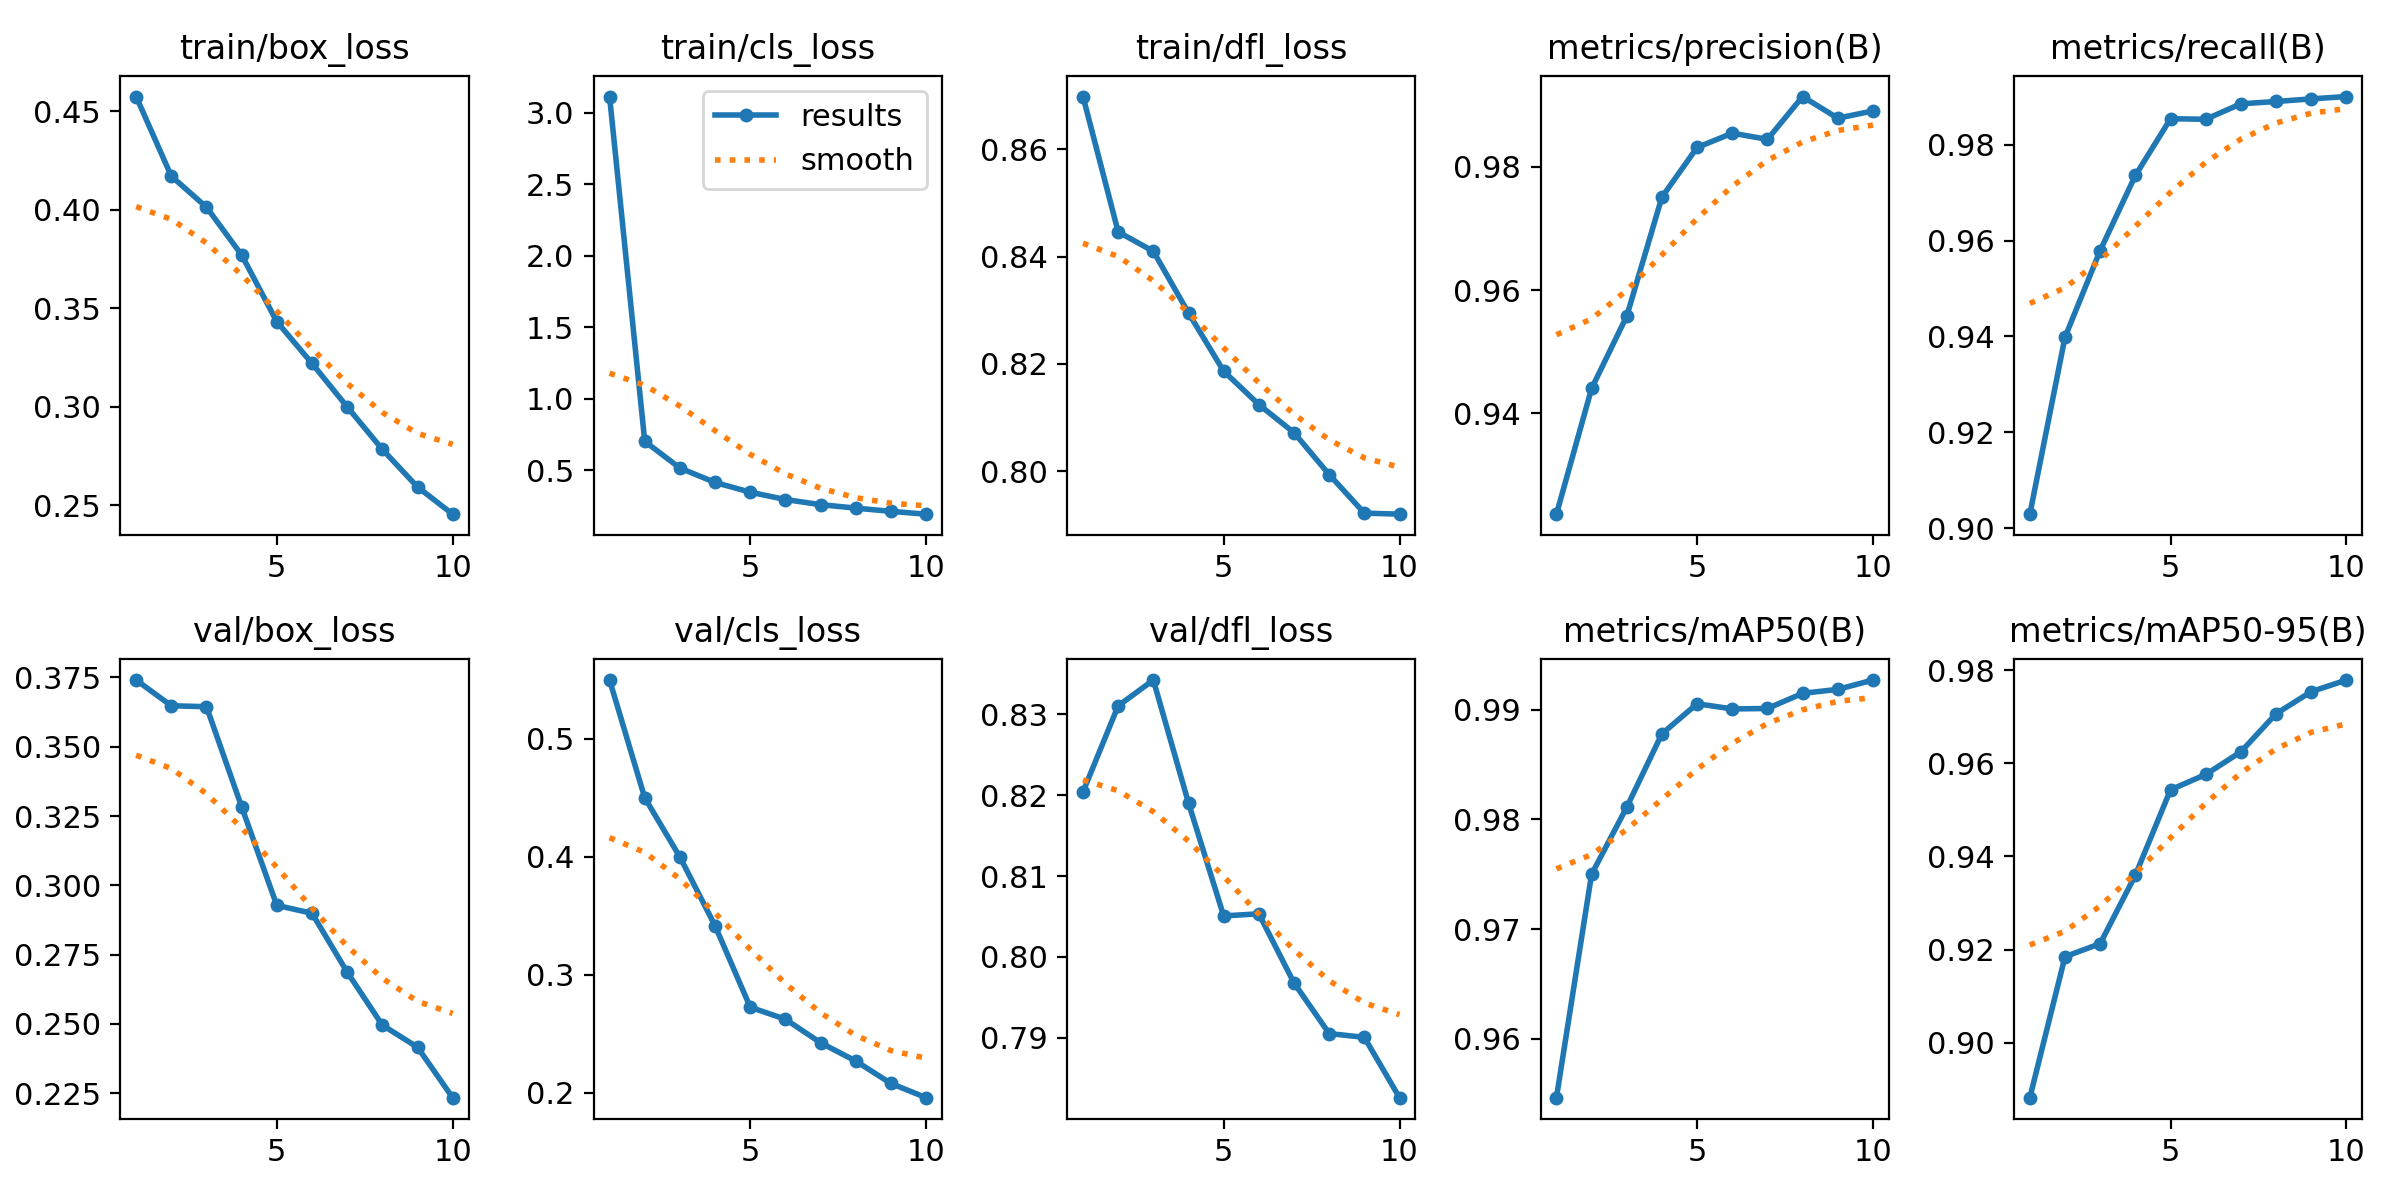

In [ ]:
# train and validation result
IPyImage(filename=f'/content/runs/detect/train/results.png', width=1000)

**Insight**
- Training conducted for 10 epochs produced a model with a precision value of 99%, recall of 99%, mAP50 of 99%, and mAP95 of 98%. These results are considered perfect for an object detection model because the mAP is almost 100% or means that all objects can be detected properly and correctly.
- In the mAP50 and mAP95 graphs, the increase in both values ​​is considered quite good because it continues to increase and there is no friction.

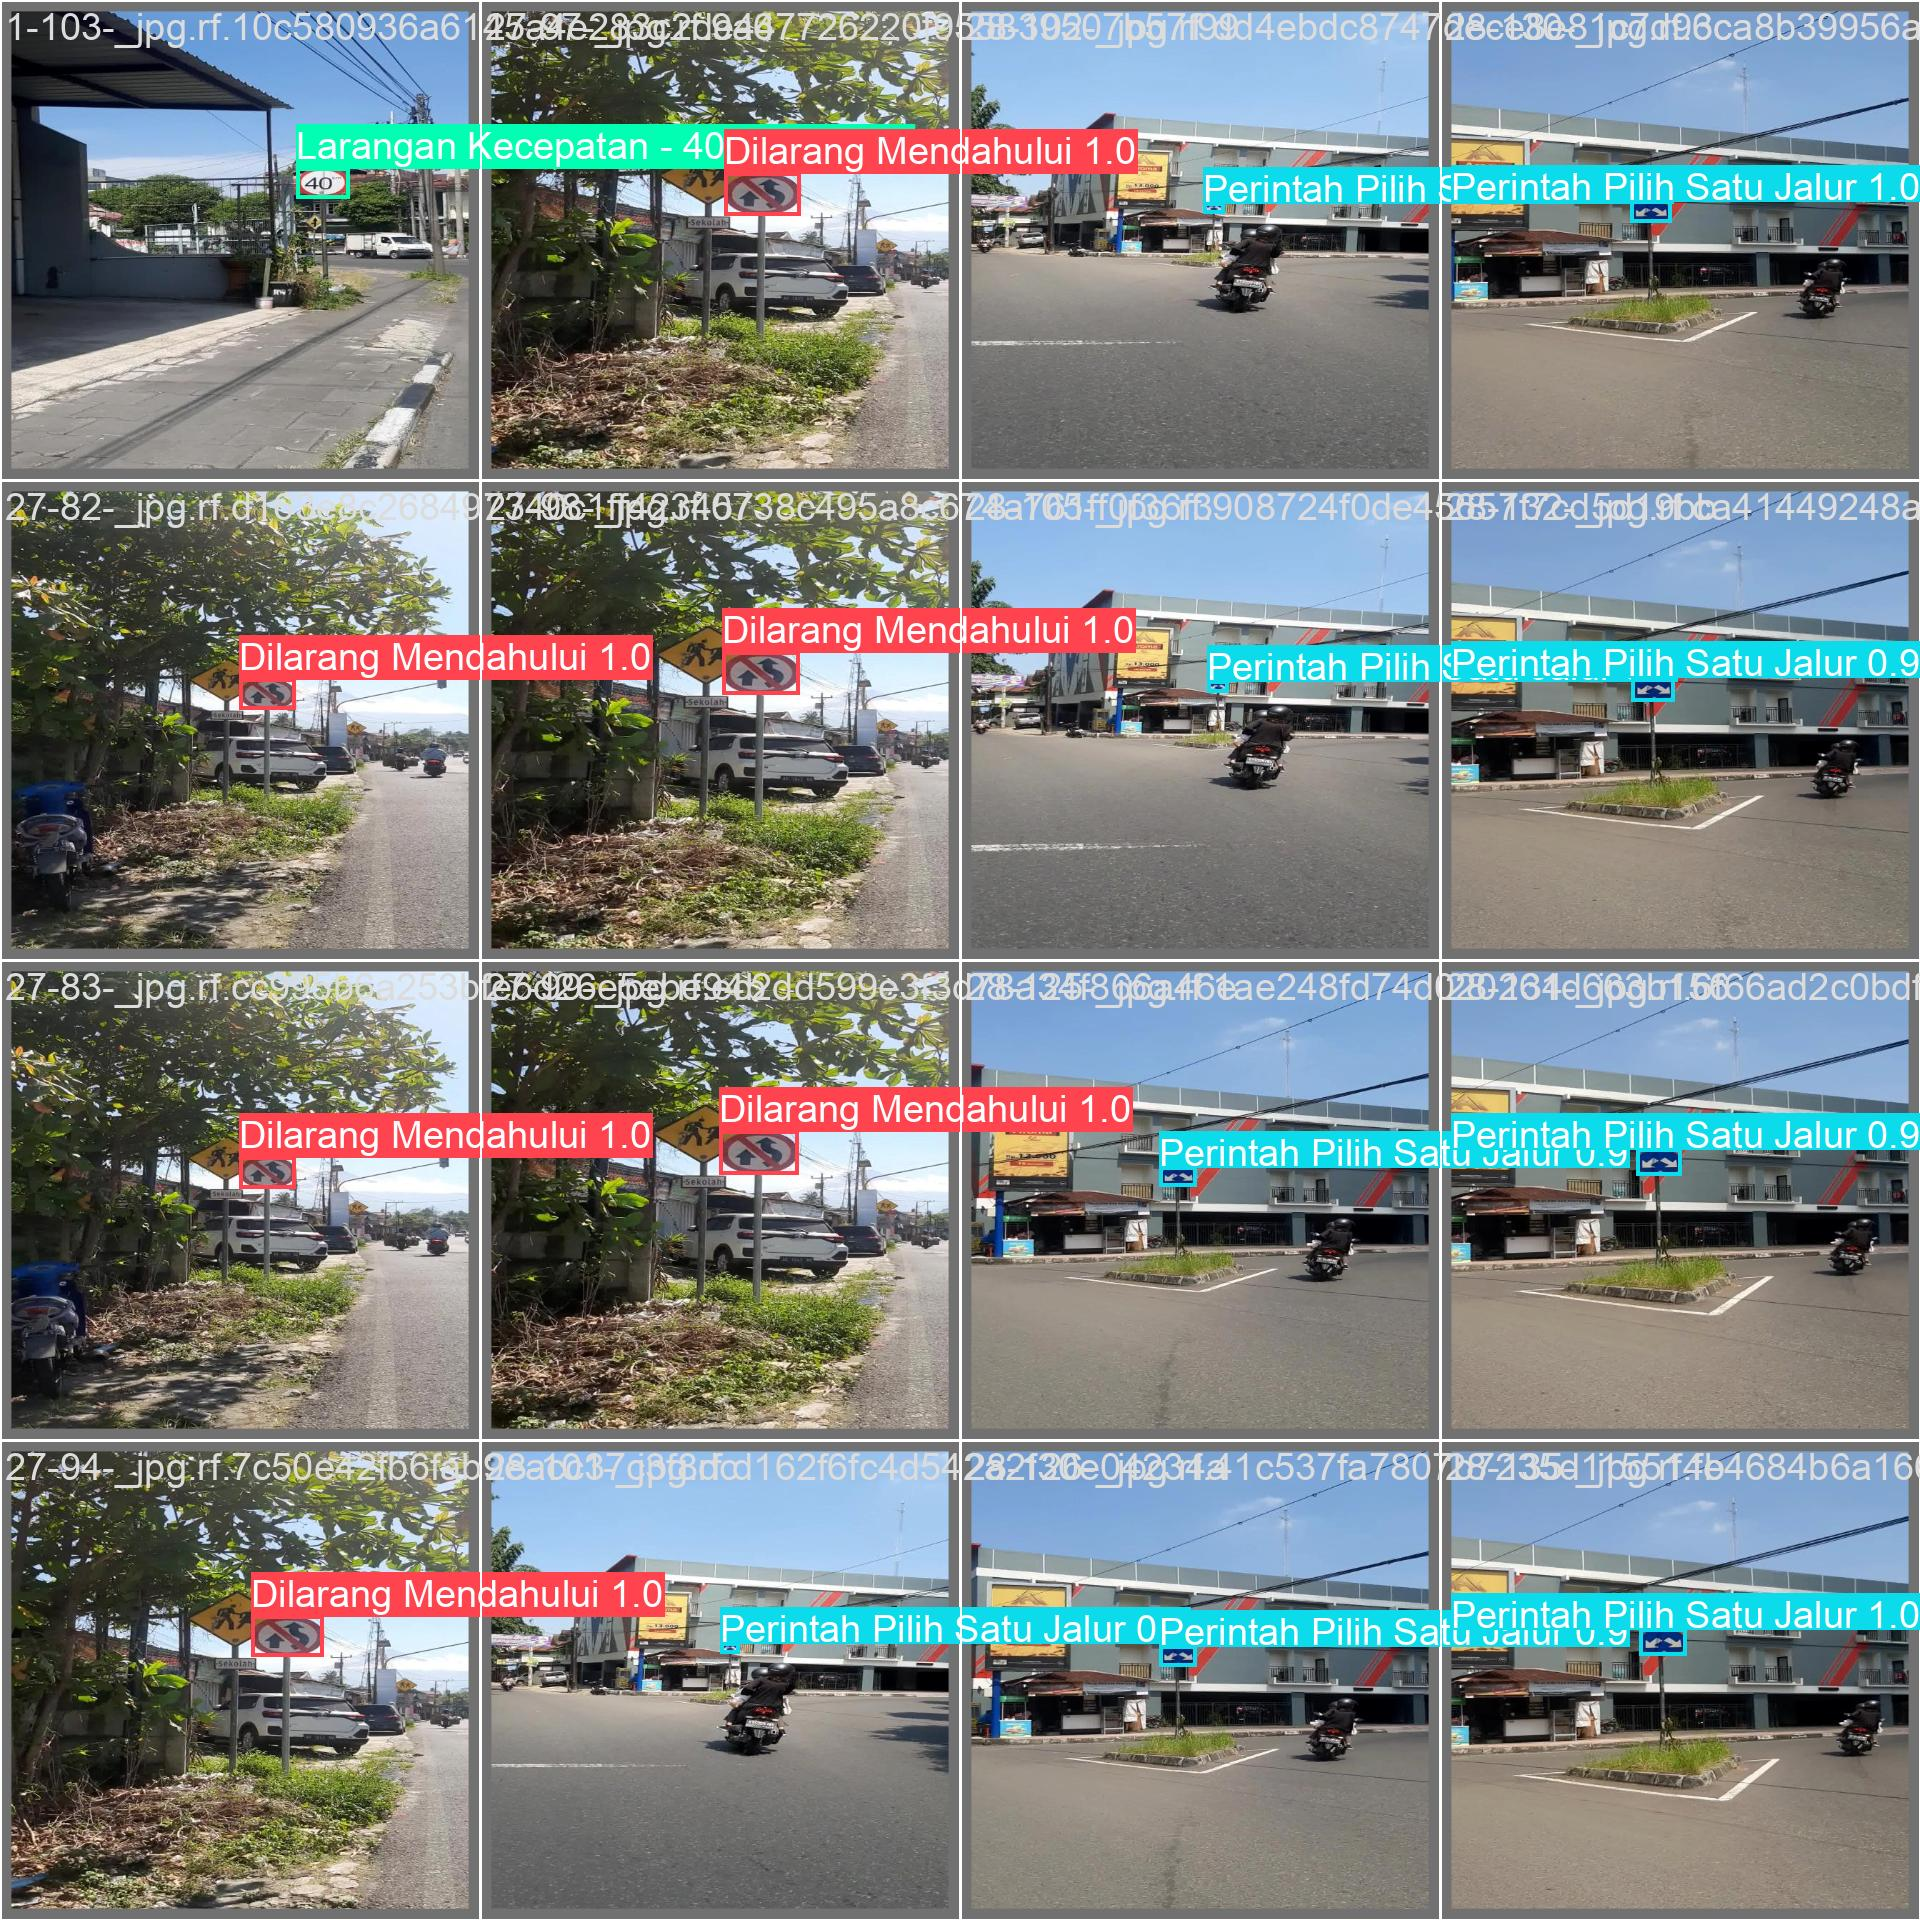

In [ ]:
# detect on validation set
IPyImage(filename=f'/content/runs/detect/train/val_batch0_pred.jpg', width=1000)

# Model Test

In [ ]:
!yolo task=detect mode=val model="/content/runs/detect/train/weights/best.pt" data="/content/traffic-sign-in-indonesia/data.yaml"

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,424,410 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/traffic-sign-in-indonesia/test/labels.cache... 466 images, 0 backgrounds, 0 corrupt: 100% 466/466 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 30/30 [00:08<00:00,  3.65it/s]
                   all        466        487      0.993      0.999      0.995      0.983
Balai Pertolongan Pertama         14         14      0.993          1      0.995      0.995
      Banyak Anak-Anak         23         23      0.996          1      0.995      0.989
  Dilarang Belok Kanan         14         14      0.996          1      0.995      0.946
     Dilarang Berhenti         19         19      0.995          1      0.995      0.988
Dilarang Berjalan Terus         17         17      0.993          1      0.995      0.995
        Dilarang Masuk         2

**Insight**
- The test results show that the average value of mAP50 is 99% and mAP95 is 98% for all classes. This shows that the model can see data that has never been seen before well because both values ​​are not different from those produced during the model validation process.

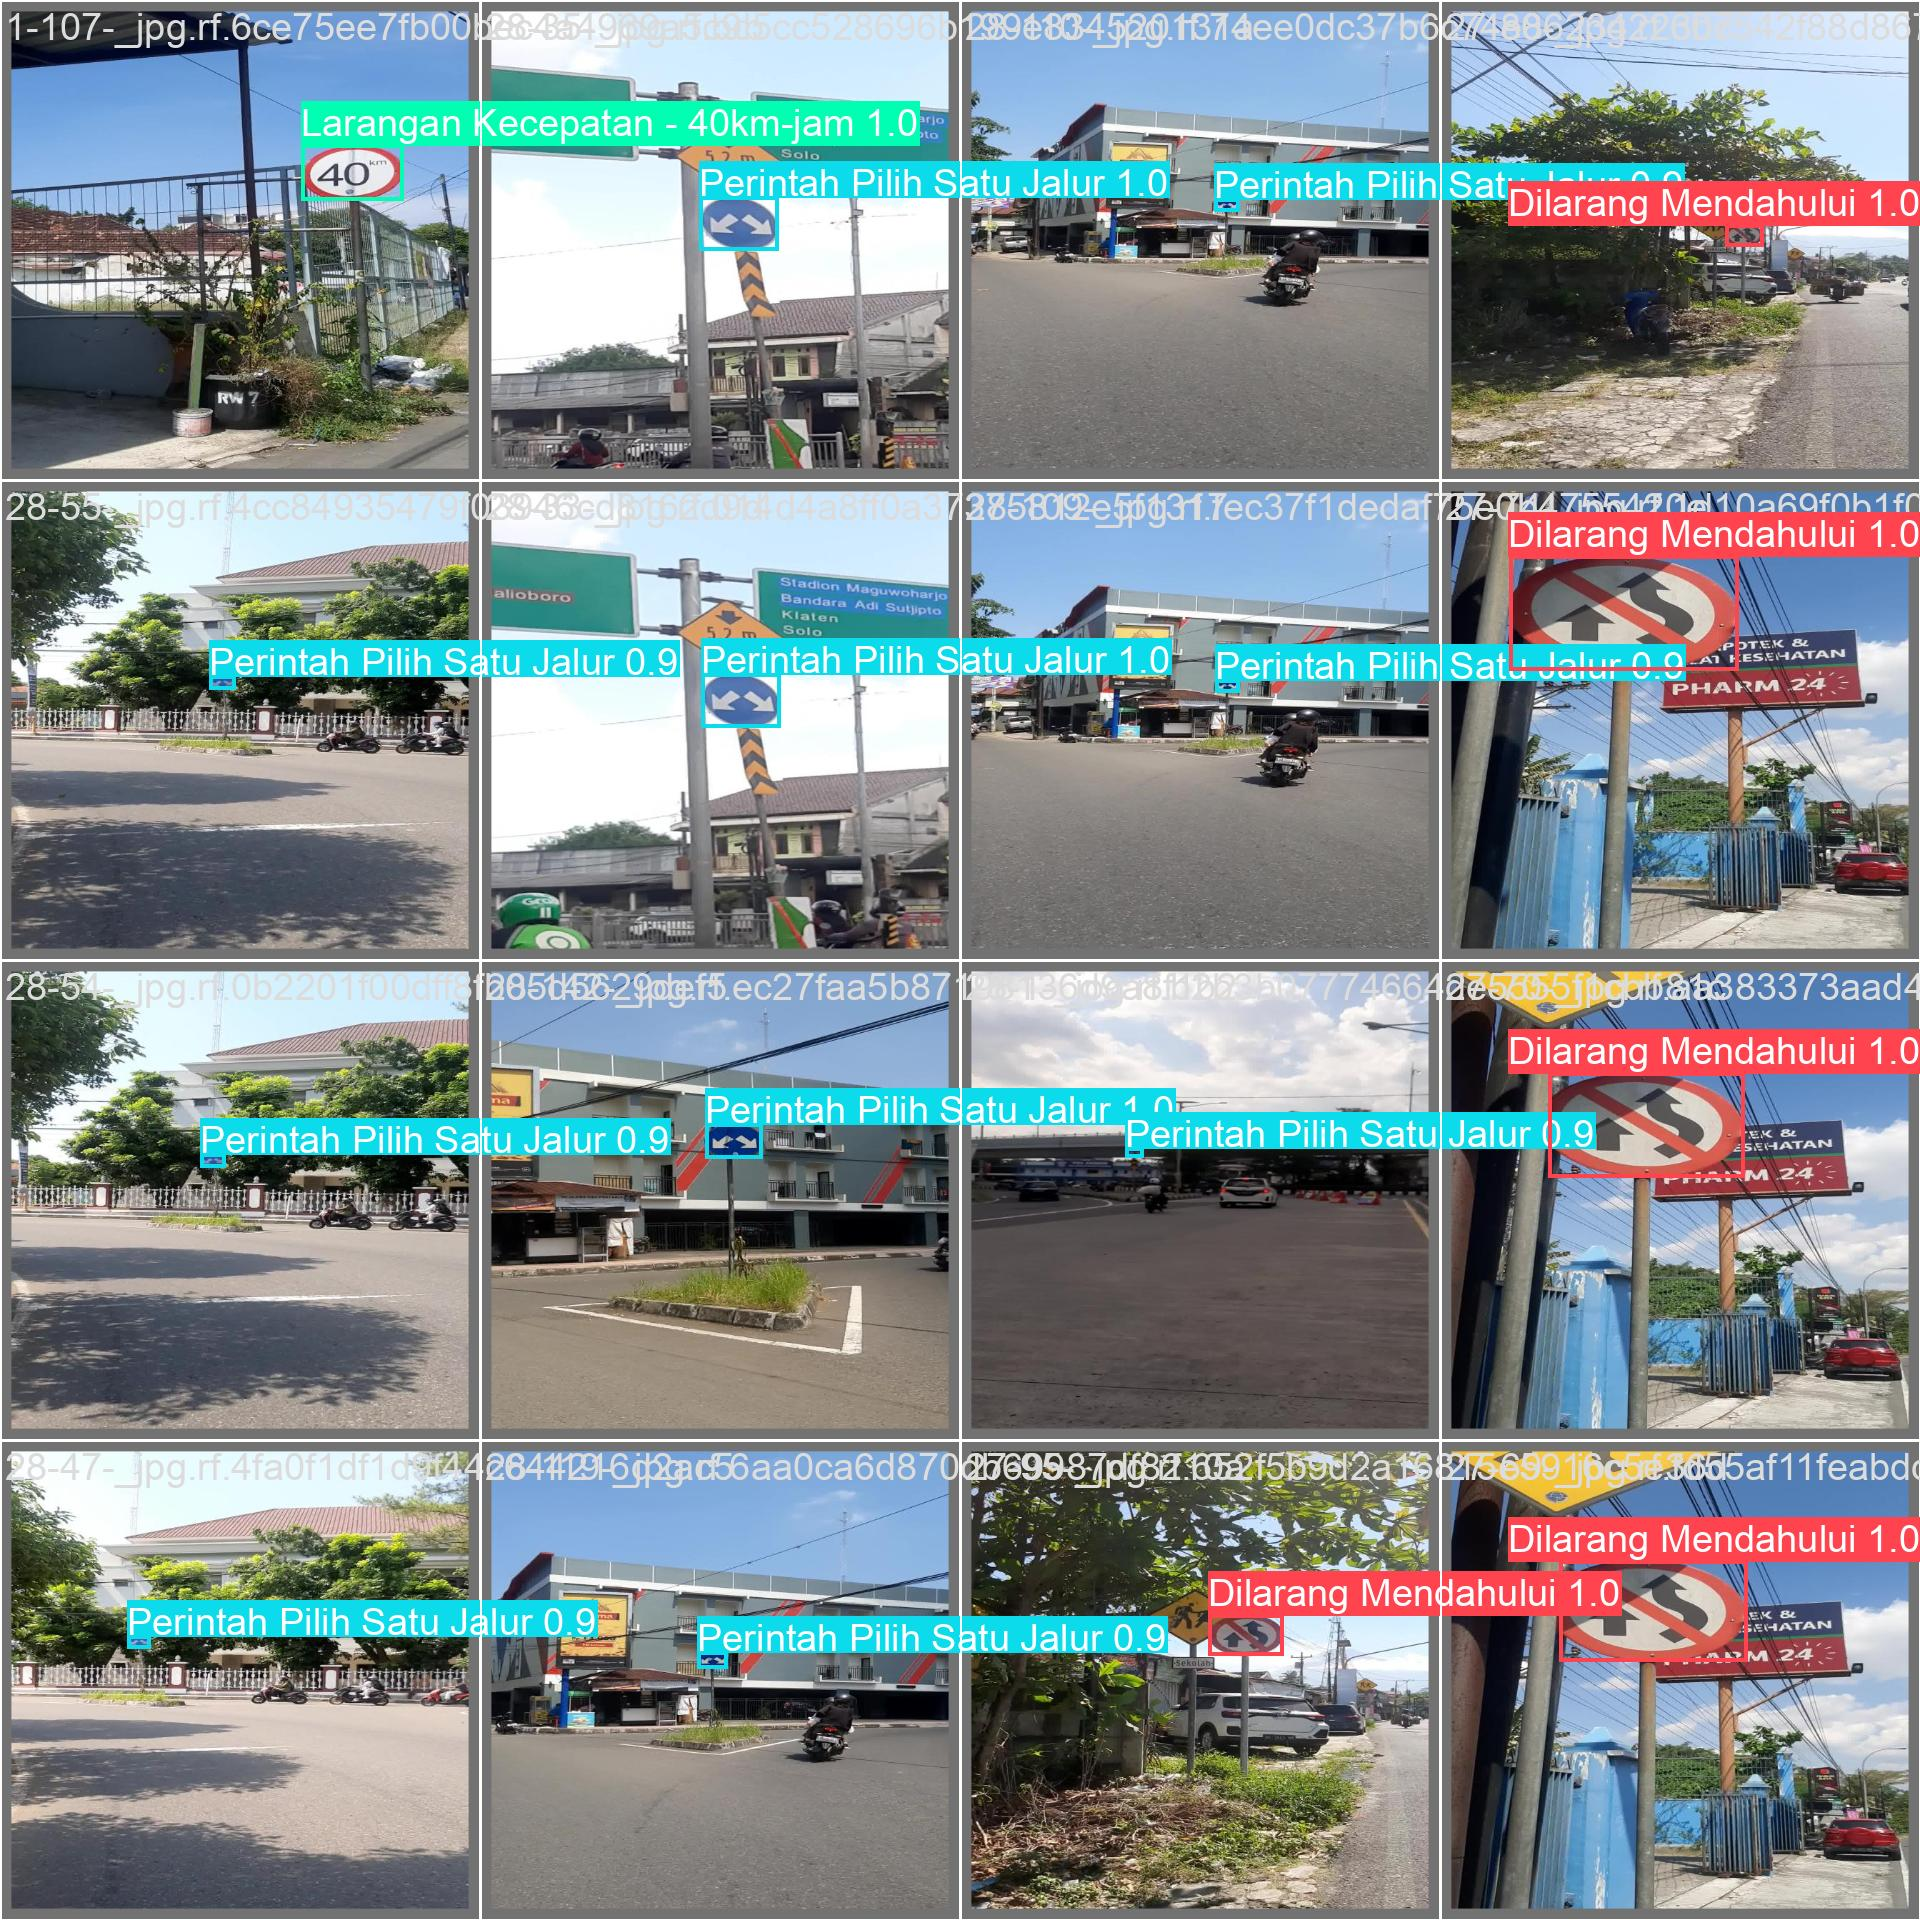

In [ ]:
# testing result
IPyImage(filename=f'/content/runs/runs/detect/val/val_batch0_pred.jpg', width=1000)

# Inference Model

In [ ]:
# inference on test dataset
!yolo task=detect mode=predict model="/content/runs/detect/train/weights/best.pt" conf=0.25 source="/content/traffic-sign-in-indonesia/test/images"

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,424,410 parameters, 0 gradients, 21.4 GFLOPs

image 1/466 /content/traffic-sign-in-indonesia/test/images/1-107-_jpg.rf.6ce75ee7fb00bec4a4969a5c9bc1604e.jpg: 640x640 1 Larangan Kecepatan - 40km-jam, 16.2ms
image 2/466 /content/traffic-sign-in-indonesia/test/images/1-117-_jpg.rf.e546db3ddc813ac62ef84fe223add139.jpg: 640x640 1 Larangan Kecepatan - 40km-jam, 15.7ms
image 3/466 /content/traffic-sign-in-indonesia/test/images/1-119-_jpg.rf.4661e1260e13e58aae94d9ca7fb392c2.jpg: 640x640 1 Larangan Kecepatan - 40km-jam, 15.6ms
image 4/466 /content/traffic-sign-in-indonesia/test/images/1-139-_jpg.rf.f901d5b0cc8f5b656b566116e370985c.jpg: 640x640 1 Larangan Kecepatan - 40km-jam, 15.6ms
image 5/466 /content/traffic-sign-in-indonesia/test/images/1-18-_jpg.rf.d5227e7d752b1cd0e4427764c301c616.jpg: 640x640 1 Larangan Kecepatan - 40km-jam, 15.6ms
image 6/466 /content/traffic-sign-in-in

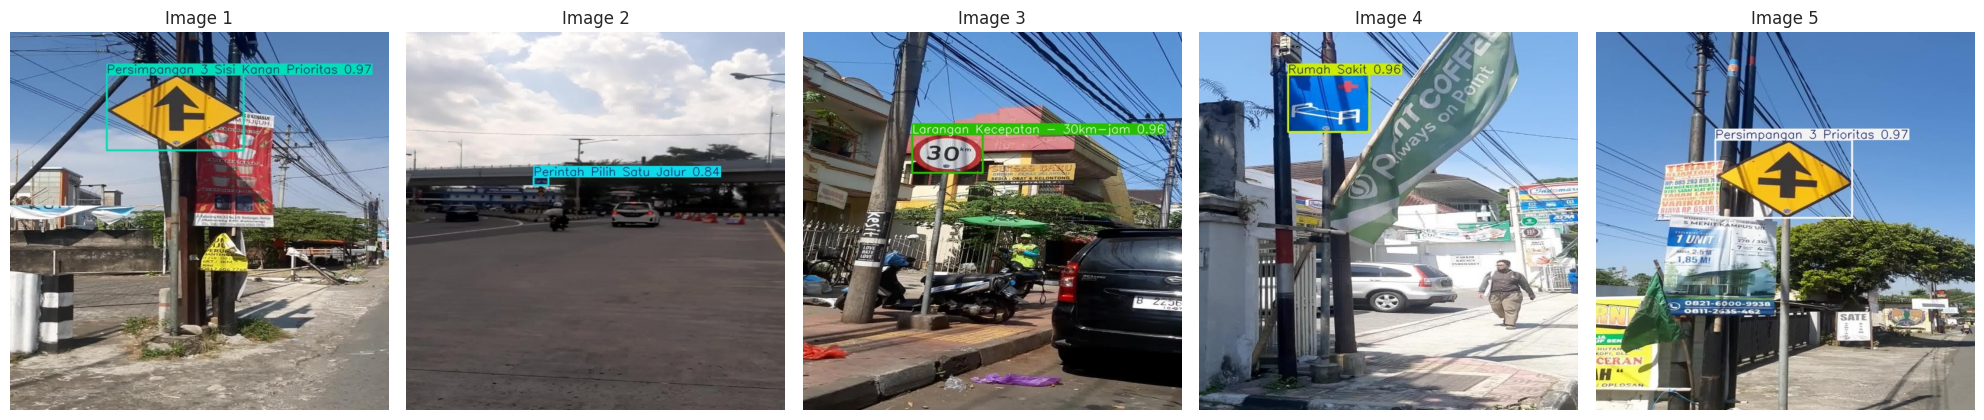

In [ ]:
folder_path = '/content/runs/runs/detect/predict'

all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
random_images = random.sample(all_images, min(5, len(all_images)))

plt.figure(figsize=(20, 10))  # Atur ukuran tampilan
for i, img_path in enumerate(random_images):
    img = Image.open(img_path)  # Buka gambar
    plt.subplot(1, 5, i + 1)    # Buat subplot (5 kolom)
    plt.imshow(img)             # Tampilkan gambar
    plt.axis('off')             # Hilangkan sumbu
    plt.title(f'Image {i+1}')   # Judul setiap gambar
plt.tight_layout()
plt.show()